In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [33]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [79]:
assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])

In [80]:
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)

id_vars = ['tid']
sample_columns = list(set(df.columns)-set(id_vars))
tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                  var_name='sample', value_name='tpm')
tpm_df.head()

,tid,sample,tpm
0,ENST00000413811.3,YRI7,0.000000
1,transcript_6675,YRI7,0.552231
2,transcript_6676,YRI7,1.184180
3,transcript_6684,YRI7,0.631121
4,transcript_6687,YRI7,0.000000


In [81]:
f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
df = pd.read_csv(f, sep='\t')
df.sort_values(by='geneid.v').head()

df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)


# get predominant transcripts per sample
id_vars = ['tid', 'gid']
sample_columns = list(set(df.columns)-set(id_vars))
df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                  var_name='sample', value_name='pi')
df = df.sort_values(by='pi', ascending=False)
df = df.drop_duplicates(subset=['gid', 'sample'], keep='first')

In [82]:
# filter based on min. cpm
df = df.merge(tpm_df, how='left',
              on=['tid', 'sample'])
min_cpm = 1
df = df.loc[df.tpm >= min_cpm]

In [83]:
df.head()

,tid,gid,sample,pi,tpm
1,transcript_361153,ENSG00000106246.18,LWK5,1.0,1.40439
2,transcript_373393,ENSG00000284116.2,YRI7,1.0,1.01557
3,transcript_370840,ENSG00000165661.18,AJI3,1.0,2.13802
6,transcript_164806,ENSG00000128510.12,PEL5,1.0,3.85113
10,transcript_7558,ENSG00000157181.16,ITU3,1.0,2.04006


In [84]:
# count the number of unique predominant transcripts per gene
# across individuals (ie not across populations)~!
temp = df[['gid', 'tid']].drop_duplicates()
temp = temp.groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
temp.head()

,gid,n_t
0,ENSG00000000419.14,1
1,ENSG00000000457.14,1
2,ENSG00000000460.17,3
3,ENSG00000000938.13,1
4,ENSG00000001036.14,1


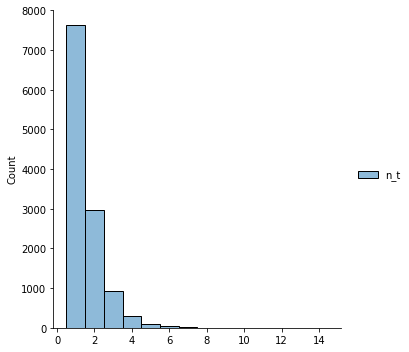

In [85]:
sns.displot(temp, kind='hist', discrete=True)

In [86]:
df.loc[df['gid']=='ENSG00000000460.17']
len(df.loc[df['gid']=='ENSG00000000460.17'])

14

In [87]:
temp.loc[temp.n_t==2]

,gid,n_t
6,ENSG00000001167.15,2
9,ENSG00000001497.18,2
23,ENSG00000003400.16,2
24,ENSG00000003402.21,2
34,ENSG00000004700.16,2
...,...,...
11976,novelGene_ENSG00000300795.1_AS,2
11977,novelGene_ENSG00000301183.1_AS,2
11980,novelGene_ENSG00000303924.1_AS,2
11983,novelGene_ENSG00000309324.1_AS,2


In [88]:
df.loc[df['gid']=='ENSG00000001167.15'].sort_values(by='sample')

,tid,gid,sample,pi,tpm
455318,transcript_160429,ENSG00000001167.15,AJI3,0.521739,1.95210
425598,transcript_160434,ENSG00000001167.15,AJI5,0.588480,2.02880
345213,transcript_160434,ENSG00000001167.15,AJI6,0.741945,1.23138
383593,transcript_160434,ENSG00000001167.15,CEU2,0.666667,1.64687
274237,transcript_160429,ENSG00000001167.15,CEU3,0.857143,1.71793
398951,transcript_160434,ENSG00000001167.15,CEU4,0.642858,1.88028
330149,transcript_160429,ENSG00000001167.15,CEU5,0.761473,2.79082
389527,transcript_160429,ENSG00000001167.15,HAC1,0.666666,1.95408
437245,transcript_160429,ENSG00000001167.15,HAC4,0.562933,1.01558
358840,transcript_160429,ENSG00000001167.15,ITU1,0.713415,2.35463


In [90]:
# plot number of unique dominant transcripts by the avg. expression 
temp2 = df[['gid', 'tpm']].groupby('gid').mean().reset_index().rename({'tpm':'mean_predom_tpm'}, axis=1)
temp2.head()

,gid,mean_predom_tpm
0,ENSG00000000419.14,72.217237
1,ENSG00000000457.14,2.201813
2,ENSG00000000460.17,1.309627
3,ENSG00000000938.13,2.880019
4,ENSG00000001036.14,10.527950


In [91]:
temp = temp.merge(temp2, on='gid', how='left')
temp.head()

,gid,n_t,mean_predom_tpm
0,ENSG00000000419.14,1,72.217237
1,ENSG00000000457.14,1,2.201813
2,ENSG00000000460.17,3,1.309627
3,ENSG00000000938.13,1,2.880019
4,ENSG00000001036.14,1,10.527950


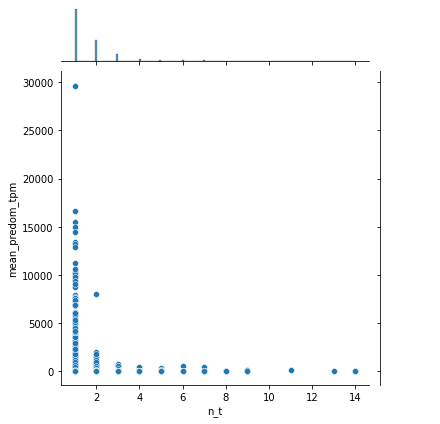

In [92]:
sns.jointplot(temp, x='n_t', y='mean_predom_tpm')